In [1]:
import networkx as nx
from math import ceil
from math import inf
import sys
import numpy as np
from queue import Queue
import matplotlib.pyplot as plt
import pulp
import pylab

## Нахождение функции расстояния

Как и предполагалось, функция расстояния будет методом линейного программирования

In [2]:
def find_max_flow(G):
    model = pulp.LpProblem("Max flow", pulp.LpMinimize)
    
    nodes = G.nodes
    lvars = pulp.LpVariable.dicts("dist",
                                         ((i, j) for i in nodes for j in nodes if i < j),
                                         lowBound=0,
                                         cat='Continuous')

    # Objective Function
    model += (
        pulp.lpSum([lvars[e] for e in G.edges])
    )

    # Constraints
    model += pulp.lpSum(lvars) >= 1

    for i in nodes:
        for j in nodes:
            for k in nodes:
                if (i, j) in lvars and (i, k) in lvars and (k, j) in lvars:
                    model += pulp.lpSum([lvars[(i, j)] - lvars[(i, k)] - lvars[(k, j)]]) <= 0
                if (i, j) in lvars and (i, k) in lvars and (j, k) in lvars:
                    model += pulp.lpSum([lvars[(i, j)] - lvars[(i, k)] - lvars[(j, k)]]) <= 0
                if (i, j) in lvars and (k, i) in lvars and (k, j) in lvars:
                    model += pulp.lpSum([lvars[(i, j)] - lvars[(k, i)] - lvars[(k, j)]]) <= 0

    # Solve problem
    model.solve(pulp.PULP_CBC_CMD(msg=0))

    d = {}
    for var in lvars:
        d[var] = lvars[var].varValue

    W = pulp.value(model.objective)
    return W, d

## Класс нахождения наименее плотного разреза

In [3]:
class LeightonRaoMinCut:
    def __init__(self, G):
        self.G = G
        self.W, self.d = find_max_flow(G)
        self.C = len(G.edges)
        self.c = 1
        self.n = len(G)
        self.delta = 1 / (2 * self.n**2)
        dist = {}
        for e in G.edges:
            dist[e] = {'dist' : self.d[e]}
        nx.set_edge_attributes(self.G, dist)
        
    def find_cut(self):
        self.partition()
        first_part, second_part = self.divide_in_two()
        
        return first_part, second_part
        
    def partition(self):
        self.parts = []

        magic_num = 4 * self.W * np.log(self.n) / self.C
        
        if self.delta <= magic_num:
            for n in self.G:
                self.parts.append([n])
            return
    
        G1 = nx.Graph()
        for e in self.G.edges:
            e_num = ceil(self.C * self.d[e] / self.W)
            if e_num == 0:
                G1.add_edge(e[0], e[1], weight=0)
            else:
                if e_num == 1:
                    G1.add_edge(e[0], e[1],weight=1)
                else:
                    G1.add_edge(e[0], "{}_{}_{}".format(e[0], e[1], 0), weight=1)
                    for i in range(e_num - 1):
                        G1.add_edge("{}_{}_{}".format(e[0], e[1], i), \
                                    "{}_{}_{}".format(e[0], e[1], i + 1), weight=1)
                    G1.add_edge("{}_{}_{}".format(e[0], e[1], e_num - 1), e[1], weight=1)

        self.G1 = G1.copy()
        C0 = 2 * self.C / self.n
        eps = self.W * np.log(self.n) / (self.delta * self.C)
        
        while True:
            v = -1
            for n in self.G:
                if n in G1:
                    v = n
            if v == -1:
                break
            dist = {}
            self.bfs(G1, v, dist)
            C_prev = C0
            v_prev = [v]
            for i in range(1, len(G1.edges) + 1):
                v_new = [j for j in G1 if j in dist and dist[j] <= i]
                Ci = len(G1.subgraph(v_new).edges)
                if (Ci < (1 + eps) * C_prev):
                    self.parts.append([i for i in v_prev if i in self.G])
                    G1.remove_nodes_from(v_prev)
                    break
                C_prev = Ci
                v_prev = v_new
        
    def divide_in_two(self):
        for part in self.parts:
            if len(part) >= 2 * self.n / 3:
                print("Found large (more then 2/3) component...")
                return self.divide_by_T(part)
        print("All components have less then 1/3 of nodes...")
        self.parts.sort(key=self.sort_key)
        
        first = []
        second = []
        
        while self.parts:
            if len(first) < self.n / 3 and len(first) + len(self.parts[-1]) < 2 * self.n / 3:
                first += self.parts.pop(-1)
            else:
                second += self.parts.pop(-1)
        
        return first, second
                
    def divide_by_T(self, T):
        dist = {}
        self.bfs(self.G1, None, dist, T)
        R = inf
        v_prev = T
        v_len_prev = len(T)
        
        first = []
        second = []
        
        for i in range(1, len(self.G1.edges) + 1):
            v_new = [j for j in self.G1 if j in dist and j in self.G and dist[j] <= i]
            v_len = len(v_new)
            if len(self.G) == v_len_prev:
                break
            Ri = (v_len - v_len_prev) / (v_len_prev * (len(self.G) - v_len_prev))
            R = min(R, Ri)
            if Ri == R:
                first = v_prev
            v_len_prev = v_len
            v_prev = v_new
        second = [i for i in self.G if i not in first]
        return first, second

    def sort_key(self, list_):
        return len(list_)

    def bfs(self, G, s, dist, T = None):
        queue = Queue()
        
        if s is not None:
            queue.put(s)
            dist[s] = 0
        visited = set()
        
        if T is not None:
            for v in T:
                dist[v] = 0
                queue.put(v)
                visited.add(v)
        while not queue.empty():
            v = queue.get()
            visited.add(v)
            for u in G[v]:
                if u not in visited:
                    queue.put(u)
                    dist[u] = dist[v] + G[v][u]['weight']

In [4]:
def vizualize_graph(G, first_part, second_part):
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=first_part, node_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=second_part, node_color='b')
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    plt.axis('off')

# Тестирование

Подготовим и протестируем несколько типовых графов для проверки достаточно хорошего решения

In [5]:
def build_graph_with_strong_components(components_num=2):
    G = nx.Graph()
    
    current_vertex = 0
    
    def build_component(component_size, current_vertex):
        for i in range(component_size):
            for j in range(i):
                G.add_edge(current_vertex + j, current_vertex + i)
        one_of_them = current_vertex
        current_vertex += component_size
        return one_of_them
    
    vertices = []
    for i in range(components_num):
        vertices.append(build_component(12, current_vertex))
        current_vertex += 12
    
    for i in range(len(vertices)):
        for j in range(i):
            G.add_edge(vertices[j], vertices[i])
    
    return G

In [6]:
def build_graph_lollipop(strong_comp_size, stick_size):
    return nx.lollipop_graph(strong_comp_size, stick_size)

In [7]:
def build_graph_compl_bip(first_size, second_size):
    return nx.complete_bipartite_graph(first_size, second_size)

In [8]:
test_graphs = []

# First graph with 2 strong components
test_graphs += [build_graph_with_strong_components(components_num=2)]

# Second graph with 3 strong components
test_graphs += [build_graph_with_strong_components(components_num=3)]

# Third graph with 4 strong components
test_graphs += [build_graph_with_strong_components(components_num=4)]

# Lollipops
test_graphs += [build_graph_lollipop(10, 5)]
test_graphs += [build_graph_lollipop(20, 3)]

# Complete biparite
test_graphs += [build_graph_compl_bip(5, 5)]
test_graphs += [build_graph_compl_bip(10, 20)]
test_graphs += [build_graph_compl_bip(3, 15)]

All components have less then 1/3 of nodes...
All components have less then 1/3 of nodes...
All components have less then 1/3 of nodes...
All components have less then 1/3 of nodes...
All components have less then 1/3 of nodes...
All components have less then 1/3 of nodes...
All components have less then 1/3 of nodes...
All components have less then 1/3 of nodes...


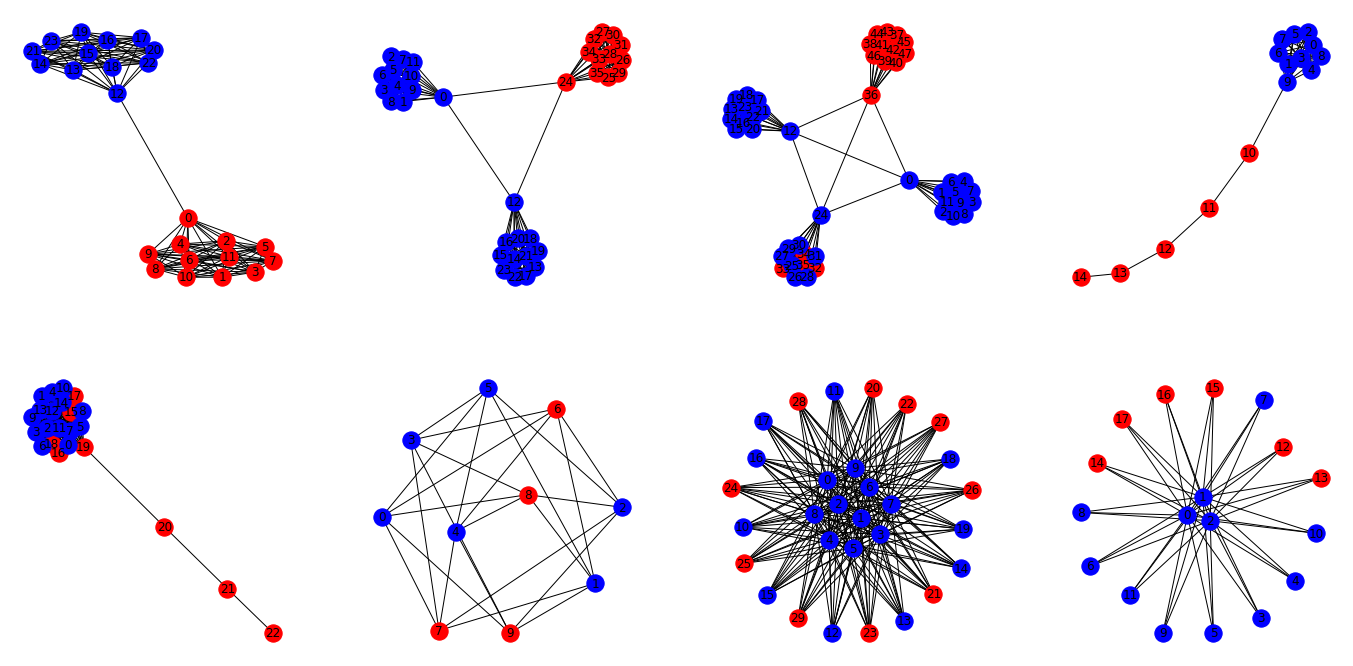

In [12]:
row_nums = ceil(len(test_graphs) / 4)
plt.figure(figsize=(24, 6 * row_nums))

for i, graph in enumerate(test_graphs):
    solver = LeightonRaoMinCut(graph)
    first_part, second_part = solver.find_cut()
    
    plt.subplot(row_nums, 4, i + 1)
    vizualize_graph(graph, first_part, second_part)

plt.savefig('test.png')

# Вывод

Как видно из построенных графов, для "гантелек" и "леденцов", алгоритм получает очень хорошие результаты. Однако на двудольных графах алгоритм довольно сильно "шумит".

Также чем больше вершин в графе, тем более красивые и "визуально правильные" результаты получаются.

Это все говорит о хорошем асимптотическом поведении, что говорит о правильной реализации